# A/B–тестирование

Входные данные:
- groups.csv - файл с информацией о принадлежности пользователя к контрольной или экспериментальной группе (А – контроль, B – целевая группа) 
- groups_add.csv - дополнительный файл с пользователями, который вам прислали спустя 2 дня после передачи данных
- active_studs.csv - файл с информацией о пользователях, которые зашли на платформу в дни проведения эксперимента
- checks.csv - файл с информацией об оплатах пользователей в дни проведения эксперимента. 

In [1]:
import pandas as pd 
import numpy as np
import requests 
from urllib.parse import urlencode 
import scipy.stats as stats
from scipy.stats import chi2_contingency, norm
from tqdm import tqdm

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

plt.style.use('ggplot')

### 1. Подготовка данных

In [3]:
def open_url(url):
    base_url = 'https://cloud-api.yandex.net/v1/disk/public/resources/download?' 
    final_url_1 = base_url + urlencode(dict(public_key=url)) 
    response = requests.get(final_url_1) 
    download_url_1 = json.loads(response.text)['href']
    return download_url_1

In [4]:
active_studs = pd.read_csv(open_url('https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ'))
checks = pd.read_csv(open_url('https://disk.yandex.ru/d/pH1q-VqcxXjsVA'), sep=';')
group_add = pd.read_csv(open_url('https://disk.yandex.ru/d/5Kxrz02m3IBUwQ?ncrnd=35815'))
groups = pd.read_csv(open_url('https://disk.yandex.ru/d/UhyYx41rTt3clQ'), sep=';')

In [5]:
active_studs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8341 entries, 0 to 8340
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   student_id  8341 non-null   int64
dtypes: int64(1)
memory usage: 65.3 KB


In [6]:
active_studs['student_id'].nunique()

8341

8341 уникальных пользователя зашло на платформу в дни эксперимента

In [7]:
groups.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 74484 entries, 0 to 74483
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      74484 non-null  int64 
 1   grp     74484 non-null  object
dtypes: int64(1), object(1)
memory usage: 1.1+ MB


In [8]:
groups['id'].nunique()

74484

In [14]:
groups.head()

,id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [9]:
group_add.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 92 entries, 0 to 91
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      92 non-null     int64 
 1   grp     92 non-null     object
dtypes: int64(1), object(1)
memory usage: 1.6+ KB


In [10]:
group_add.head()

,id,grp
0,5694584,B
1,5694830,B
2,5695057,B
3,5698872,B
4,5699067,B


In [11]:
group_add['id'].nunique()

92

In [12]:
checks.head()

,student_id,rev
0,1627,990.0
1,3185,690.0
2,25973,690.0
3,26280,690.0
4,100300,990.0


In [13]:
checks.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541 entries, 0 to 540
Data columns (total 2 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  541 non-null    int64  
 1   rev         541 non-null    float64
dtypes: float64(1), int64(1)
memory usage: 8.6 KB


In [16]:
checks['student_id'].nunique()

541

В каждом датафрейме только уникальные id пользователей. Объединим данные groups и groups_add, предварительно проверив нет ли общих id студентов

In [17]:
duplicates = pd.merge(groups, group_add, how='inner', on=['id'])
duplicates.head()

,id,grp_x,grp_y


в данных нет дупликатов id

In [18]:
groups_full = pd.concat([groups, group_add]).rename(columns={'id': 'student_id'})
groups_full.head()

,student_id,grp
0,1489,B
1,1627,A
2,1768,B
3,1783,B
4,1794,A


In [19]:
groups_full.shape

(74576, 2)

В датасет active_studs добавим столбец активных пользователей, после этого объединим данные с группами пользователей и чеками

In [20]:
active_studs['active'] = 1
active_studs.head()

,student_id,active
0,581585,1
1,5723133,1
2,3276743,1
3,4238589,1
4,4475369,1


In [21]:
df_merged = groups_full.merge(active_studs, how='left', on='student_id').fillna(0) \
    .merge(checks, how='left', on='student_id').fillna(0) 
df_merged.head()

,student_id,grp,active,rev
0,1489,B,0.0,0.0
1,1627,A,1.0,990.0
2,1768,B,0.0,0.0
3,1783,B,0.0,0.0
4,1794,A,0.0,0.0


In [22]:
df_merged.shape[0]

74576

In [23]:
df_merged.student_id.nunique()

74576

Убедились, что в полученном датасете только уникальные id. Далее оценим студентов по активности и чекам

In [24]:
df_merged.groupby('active').agg({'student_id': 'count', 'rev': 'sum'})

,student_id,rev
active,,
0.0,66235,105532.0001
1.0,8341,467794.0035


In [25]:
df_merged.query('active == 0 and rev > 0').student_id.count() 

149

In [34]:
df_merged.query('active == 0 and rev > 0').rev.value_counts()

690.0000     61
290.0000     24
990.0000     19
1140.0000    14
199.0000     14
580.0000      4
1900.0000     4
840.0000      3
398.0000      2
630.0000      1
1980.0000     1
1180.0000     1
1900.0001     1
Name: rev, dtype: int64

Среди неактивных студентов 149 пользователей совершили оплату в дни проведения АВ-теста, возможно у этих пользователей настроен автоплатеж и они пассивно участвовали в проведении эксперимента(у большинства пользователей чек 690 р, что может говорить о ежемесячной оплате подписки, у остальных - возможно оплата товара после получения). Т.к. неактивные юзеры не тестировали новую механику,они не могут влиять на рез-ты проведения АВ-теста, поэтому оставим в датасете только id активных пользователей

In [26]:
df = df_merged.query('active == 1')

In [27]:
df.groupby('grp').agg({'student_id': 'count'})

,student_id
grp,
A,1538
B,6803


Отметим неравномерное количество студентов по группам А и В, далее оценим чеки

In [29]:
df.rev.value_counts()

0.0000       7949
1900.0000      93
290.0000       70
1900.0001      35
199.0000       32
840.0000       24
990.0000       22
690.0000       17
1140.0000      11
580.0000       11
590.0000       11
1530.0000       8
398.0000        7
870.0000        6
3660.0000       5
2910.0000       4
2890.0000       4
489.0000        3
1160.0000       3
1980.0000       3
2099.0000       3
2820.0000       2
2220.0000       2
3260.0000       1
597.0000        1
1339.0000       1
1180.0000       1
1968.0000       1
1050.0000       1
1830.0000       1
1388.0000       1
2900.0000       1
1729.0000       1
2190.0000       1
4650.0000       1
796.0000        1
3040.0000       1
880.0000        1
1039.0000       1
Name: rev, dtype: int64

In [32]:
df.rev.value_counts().reset_index().sort_values('index' , ascending=False)

,index,rev
34,4650.0000,1
14,3660.0000,5
23,3260.0000,1
36,3040.0000,1
15,2910.0000,4
31,2900.0000,1
16,2890.0000,4
21,2820.0000,2
22,2220.0000,2
33,2190.0000,1


In [35]:
df.groupby('grp').agg({'rev': 'sum'})

,rev
grp,
A,72820.0000
B,394974.0035


Большинство активных юзеров не оформляли покупок. Среди тех, кто оформил заказ, активнее пользователи из группы. Также чаще встречаются чеки на 1900/1900.0001 (подсчет возможно связан с числами с плавающей точкой), необходимо уточнить не проводилось ли в эти дни акция или это новые пользователи и для них есть выгодное приложение, обе эти причины могли повлиять на результаты проведения а/в теста. 

### 2. Выбор метрик 

Для того чтобы запускать новую механику оплаты, необходимо оценить как она влияет на прибыль. Какие метрики будем смотреть?

 - конверсия в покупку (CR) - покажет процентное соотнощение пользователей, которые осуществили целевое действие - оформили заказ на сайте,
 
- ARPU, или средняя выручка на одного пользователя показывает, покажет сколько денег в среднем приносит компании 1 пользователь,

- ARPPU, или средняя выручка на одного клиента - это метрика, которая помогает оценить ценность продукта с точки зрения клиентов и оценить сколько денег в среднем приносит компании 1 клиент  

### CR

__Формула расчета конверсии = количество транзакций/количество сессий × 100%__

с учетом того, что в датасете только уникальные пользователи, то количество транзакций = количество клиентов, количество сессий = общее число юзеров.

Для расчета клиентов создадим колонку client, которая будет показывать является ли юзер клиентом(True - совершил покупку) или нет(False - не покупал). Далее рассчитаем среднее в колонке по группам, что и будет являться конверсией.

In [27]:
df['client'] = df['rev'] > 0 

C:\Users\ezhiv\AppData\Local\Temp\ipykernel_18380\705399706.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['client'] = df['rev'] > 0


In [28]:
df.query('grp == "A"')['client'].mean() * 100

5.071521456436931

In [29]:
df.query('grp == "B"')['client'].mean() * 100

4.615610759958842

In [30]:
(df.query('grp == "B"')['client'].mean() * 100) - (df.query('grp == "A"')['client'].mean() * 100)

-0.4559106964780888

По рез-там вычислений в группе с новой механикой оплаты метрика CR стала хуже.

#### Выбор статистического критерия

Так как статистика конверсии будет оцениваться по колонкам 'grp'(группа А, группа В) и 'client'(True, False),а данные в этих колонках являются категориальными переменными, то для расчета статистики используем критерий хи-квадрат. Для этого создадим таблицу сопряженности и убедимся, что требования для расчета статистики удовлетворяются: наблюдения не  зависимы; в каждой ячейке более 5 значений

In [31]:
pd.crosstab(df.client, df.grp)

grp,A,B
client,,
False,1460,6489
True,78,314


Требования: наблюдения не зависимы - выполняется; в каждой ячейке более 5 значений - выполняется.

формулируем гипотезу:
- H0- новая механика оплаты не влияет на конверсию
- H1- новая механика оплаты влияет на конверсию(при этом мы не можем утверждать, как именно влияет)

Уровень стат.значимости 5%

In [32]:
stat, p, dof, ex = chi2_contingency(pd.crosstab(df.client, df.grp))

In [33]:
stat, p, dof, ex

(0.48480826522557896,
 0.48625240457231045,
 1,
 array([[1465.71897854, 6483.28102146],
        [  72.28102146,  319.71897854]]))

Вывод: т.к. по результатам теста значение достоверности p > 0.05, что не дает нам права отвергнуть нулевую гипотезу об отсутствии различий, можем сделать вывод, что новая механика оплаты не влияет на метрику конверсии.

### ARPU

Расчет ARPU, или средняя выручка на одного пользователя расчитывается по формуле: 

__весь доход / количество пользователей за период__

С учетом уникальных пользователей мы можем посчитать среднее значение по колонке rev, это и будет средней выручкой на 1 пользователя

In [34]:
df.query('grp == "A"').rev.mean()

47.34720416124838

In [35]:
df.query('grp == "B"').rev.mean()

58.05879810377776

In [36]:
(df.query('grp == "B"').rev.mean()) - (df.query('grp == "A"').rev.mean())

10.711593942529383

По полученным рез-там, в группе с новой механикой оплаты показатель ARPU увеличился. 

Оценим графически распределения групп в зависимости от выручки

array([<AxesSubplot:title={'center':'A'}>,
       <AxesSubplot:title={'center':'B'}>], dtype=object)

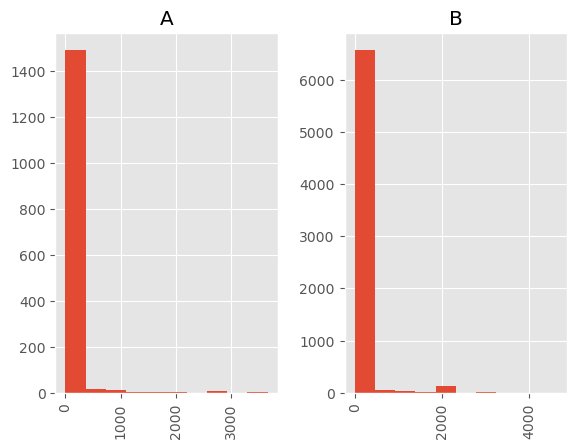

In [37]:
df.hist(column='rev', by='grp')

При расчете % соотношения платящих/неплатящих выявлено, что только ~5% пользователей оформили покупку. Также визуально признак выручки распределен ненормально в обеих выборках, убедимся в полученных рез-тах, используя функцию normaltest из модуля stats(Н0 - распределение нормальное, Н1-распределение отклоняется от нормального)

In [38]:
df.query('grp == "A" and client')['client'].count() / df.query('grp == "A"')['client'].count() * 100

5.071521456436931

In [39]:
df.query('grp == "B" and client')['client'].count() / df.query('grp == "B"')['client'].count() * 100

4.615610759958842

__Выбор статистического критерия__

Группы контроля и тестовая и при визуализации и при проверке с помощью функции normaltest имеют ненормальное распределение, т.к. только ~5% пользователей в обеих группах оформили покупку. Можно считать эти значения выбросами, тогда выбор и применение статистических критериев для оценки метрики ARPU в данном случае не имеет смысла. Проведем tt-тест, для того чтобы подтвердить свои убеждения:

Формулируем гипотезу:

H0. Изменение механики оплаты не влияет на метрику ARPU.

H1. Если мы изменим механику оплаты, то увеличим показатель APPU.

Выберем уровень стат.значимости 5% 

In [42]:
stats.ttest_ind(test_group, control_group)

Ttest_indResult(statistic=1.2253411073793445, pvalue=0.22048133326988378)

Вывод: по результатам теста p > 0.05, что не дает нам права отвергнуть нулевую гипотезу о равенстве средних, таким образом можно сделать вывод, что изменение механики оплаты не отразится на метрике ARPU.

### ARPPU

Расчет ARPPU, или средняя выручка на одного клиента рассчитывается по формуле:   
__весь доход / количество клиентов за период__

Оставим в датасете только клиентов и посчитаем среднее по колонке rev

In [43]:
df_filtered = df[df['rev'] != 0]
df_filtered.head()

,student_id,grp,active,rev,client
1,1627,A,1.0,990.0000,True
220,100300,B,1.0,990.0000,True
320,108270,B,1.0,290.0000,True
3779,264473,B,1.0,1900.0001,True
4187,274352,B,1.0,690.0000,True


In [44]:
df_filtered.groupby('grp').agg({'rev': 'count'})

,rev
grp,
A,78
B,314


In [45]:
df_filtered.query('grp == "A"').rev.mean()

933.5897435897435

In [46]:
df_filtered.query('grp == "B"').rev.mean()

1257.878992038217

In [47]:
(df_filtered.query('grp == "B"').rev.mean() - df_filtered.query('grp == "A"').rev.mean())

324.28924844847336

По полученным рез-там, в группе с новой механикой оплаты показатель ARPPU увеличился.

Оценим графически распределения групп в зависимости от выручки, после оценим нормальность распределений, используя функцию normaltest из модуля stats(Н0 - распределение нормальное, Н1-распределение отклоняется от нормального)

array([<AxesSubplot:title={'center':'A'}>,
       <AxesSubplot:title={'center':'B'}>], dtype=object)

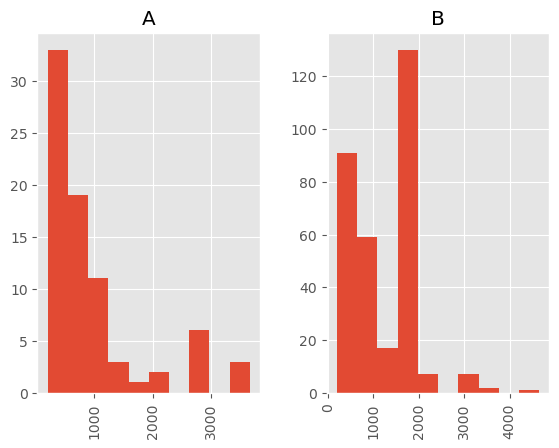

In [48]:
df_filtered.hist(column='rev', by='grp')

In [49]:
control_group1 = df_filtered.query('grp == "A"').rev

stats.normaltest(control_group1)

NormaltestResult(statistic=30.378419638487475, pvalue=2.5316868804220266e-07)

In [50]:
test_group1 = df_filtered.query('grp == "B"').rev

stats.normaltest(test_group1)

NormaltestResult(statistic=6.795662714490353, pvalue=0.033445723194625424)

__Выбор статистического критерия__

Группы контроля и тестовая при проверке с помощью функции normaltest имеют нормальное распределение. Так как наши группы небольшие по объему, применим бутстреп анализ

Формулируем гипотезу:
- H0. Изменение механики оплаты не влияет на метрику ARPPU.
- H1. Если мы изменим механику оплаты, метрика ARPPU вырастет.

Выберем уровень стат.значимости 5%

In [51]:
def get_bootstrap(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            len(data_column_1), 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            len(data_column_1), 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1)-statistic(samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
        
    # Визуализация
    _, _, bars = plt.hist(pd_boot_data[0], bins = 50)
    for bar in bars:
        if bar.get_x() <= quants.iloc[0][0] or bar.get_x() >= quants.iloc[1][0]:
            bar.set_facecolor('red')
        else: 
            bar.set_facecolor('grey')
            bar.set_edgecolor('black')
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

100%|████████████████████████████████████████████████████████████████████████████| 1000/1000 [00:00<00:00, 1384.44it/s]


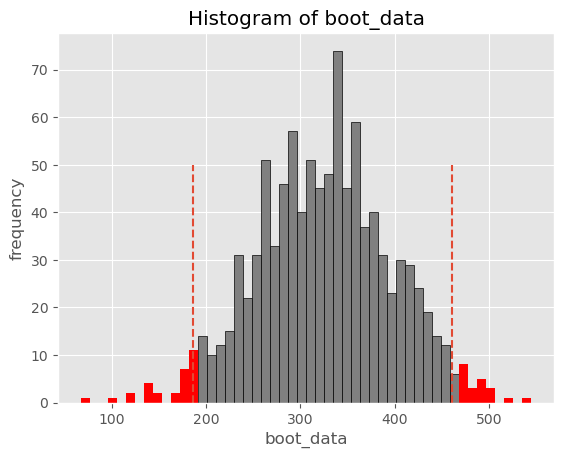

In [52]:
booted_data_rev = get_bootstrap(test_group1, control_group1)


In [53]:
booted_data_rev["p_value"]

4.301994304342282e-06

Вывод: по результатам теста p<0.05, что дает нам право отвергнуть нулевую гипотезу о равенстве средних и сделать вывод, что изменение механики оплаты отразится на метрике ARPPU

## Вывод:
### Стоит ли запускать новую механику на всех пользователей?

- В ходе анализа первое, было выявлено неравномерное распределение по группам. В эксперименте участвовало 8341 пользователей. В контрольной группе 1538 это 18% от общего числа. В тестовой группе 6803 почти 82% от общего числа. 
- Были обнаружены 149 пользователей, которые совершили оплату, но без посещения образовательной платформы во время проведения эксперимента, возможно у них подключен автоплатеж, этих пользователей не учитывали при расчете метрик. 
- Предварительный анализ показал, что в группе б пользователи вели себя активно и самый популярный чек был на 1900, можно предположить, что в дни проведения эксперимента была запущена акция/выгодное предложение либо это были новые пользователи. Все перечисленные причины могли исказить результаты теста. 
- Выделено 3 метрики для оценки влияния новой механики оплаты на прибыль: CR, ARPU, ARPPU. 
- В ходе проведенного анализа выявлено, что метрики CR и ARPU не показали статистически значимых различий у пользователей с новой механикой оплаты(p-value > 0.05), в то же время статистика метрики ARPPU показала статистически значимое увеличение(p-value = 0.00186). Повторюсь, на рез-ты теста могла повлиять запущенная акция/рекл компания/выгодное предложение для новых пользователей. 
- Механика оплаты повлияла только на доход от платящих пользователей, но не повлияла на конверсию. Скорее всего на увеличение среднего чека платящих пользователей повлиял не запуск новой механики оплаты, а что-то другое. Рекомендовано не катить новую механику оплаты на всех пользователей, а разобраться, что могло повлиять на увеличение ARPPU и как были сформированы группы для теста.


--

#### Реализация функций по автоматизации и визуализации метрик

In [54]:
def calculate_metrics(url_1, url_2, url_3, url_4):
    active_studs = pd.read_csv(open_url(url_1))
    checks = pd.read_csv(open_url(url_2), sep=';')
    group_add = pd.read_csv(open_url(url_3))
    groups = pd.read_csv(open_url(url_4), sep=';')
    
    # отмечаем активных студентов 
    active_studs['activity'] = 1
    
    # объединяем данные
    groups_full = pd.concat([groups, group_add]).rename(columns={'id': 'student_id'}).reset_index(drop=True)
    df_merged = groups_full.merge(active_studs, how='left', on='student_id').fillna(0) \
        .merge(checks, how='left', on='student_id').fillna(0).reset_index(drop=True)
    
    # оставляем в датасете только активных пользователей,оцениваем есть ли дубли, считаем метрики:
    df = df_merged.query('activity == 1')
    df['client'] = df.rev > 0  
    if df_merged.shape[0] == df_merged.student_id.nunique():
        CR = df.groupby('grp').agg({'client': 'mean'}).rename(columns={'client': 'CR, %'})
        CR['CR, %'] *= 100
        arpu = df.groupby('grp').agg({'rev': 'mean'}).rename(columns={'rev': 'ARPU'})
        arppu = df.query('rev > 0').groupby('grp').agg({'rev': 'mean'}).rename(columns={'rev': 'ARPPU'})
        metrics = CR.merge(arpu, how='left', on='grp').merge(arppu, how='left', on='grp')
        return metrics
    else:
        print("Не уникальные пользователи")


In [55]:
metrics = calculate_metrics(
                'https://disk.yandex.ru/d/Tbs44Bm6H_FwFQ',
                'https://disk.yandex.ru/d/pH1q-VqcxXjsVA',
                'https://disk.yandex.ru/d/5Kxrz02m3IBUwQ',
                'https://disk.yandex.ru/d/UhyYx41rTt3clQ',
                )
print(metrics)

        CR, %       ARPU        ARPPU
grp                                  
A    5.071521  47.347204   933.589744
B    4.615611  58.058798  1257.878992


C:\Users\ezhiv\AppData\Local\Temp\ipykernel_18380\1108084370.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['client'] = df.rev > 0


In [56]:
def metrics_plot(metrics):
    sns.set(
        font_scale=1,
        style="whitegrid",
        rc={'figure.figsize': (4, 15)}
    )
    axes = metrics.plot.bar(rot=0, subplots=True)
    axes[1].legend(loc=0)    

In [57]:
def get_plot(metrics):
    figure, ax = plt.subplots(1, 3, figsize=(20,5))
    
    ax_1 = sns.barplot(data=metrics, x='group', y='CR', ax=ax[0])
    ax_2 = sns.barplot(data=metrics, x='group', y='ARPU', ax=ax[1])
    ax_3 = sns.barplot(data=metrics, x='group', y='ARPPU', ax=ax[2])

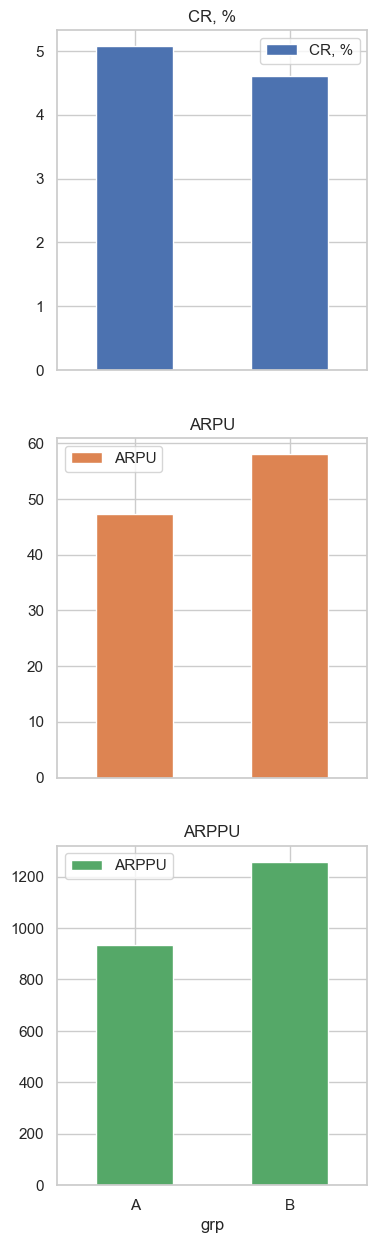

In [58]:
metrics_plot(metrics)